# Deep Learning Tutorial with PyTorch!
Along with having a read through and executing the code there are a number of tasks dotted throughout the notebook!

Please make a copy of this notebook.


**Author**: Harry Coppock harry.coppock@imperial.ac.uk


# Part 1: Building a CNN Classifier in PyTorch
In this section the steps to build a Convolutional Neural Network (CNN) classifier are detailed. The task is to classify a set of images from the animal kingdom into 20 classes (Lion, Elephant, etc...). You are invited to have a play around with the code. There are also a series of tasks aimed at developing you PyTorch coding skills!

##Importing the necessary packages

In [ ]:
# Standard numpy packages - Colab already as a lot of the basic functionality 
# already installed, therefore there is no need to pip install

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.animation as animation

torchvision contains some very useful image processing methods and the dataset is on gdrive so gdown will help us load the data. Note the ! to move the commmand to the machine's terminal

In [ ]:
!pip install torch torchvision
!pip install gdown

Pytorch is a widely used deeplearning library, please see https://pytorch.org/ for more info.

In [ ]:
# Pytorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F

## Setting up the GPU


In [ ]:
# device selection - Colab offers free GPUs!
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
  print('Please first activate the GPU by going Runtime>Change Runtime type')
  device = torch.device("cpu")
print('The device that will be used is:',device)

The device that will be used is: cuda:0


## If you want to save files to the google drive you need to first mount the drive:

In [ ]:
# # uncomment if you want to save images to your Gdrive
# from google.colab import drive
# drive.mount('/content/drive')

## Importing subset of Imagenet, termed NaturalImageNet
Made for the purpose of this tutorial  (to make the learning process more fun!) NaturalImageNet contains 20 classes all selected from the animal kindom!

In [ ]:
!gdown https://drive.google.com/uc?id=1H7vjiEkxg5lPs1WxhMZ9AQgcXT32XQM7

Downloading...
From: https://drive.google.com/uc?id=1H7vjiEkxg5lPs1WxhMZ9AQgcXT32XQM7
To: /content/NaturalImageNet.zip
1.52GB [00:13, 111MB/s] 


In [ ]:
!unzip /content/NaturalImageNet.zip

Streaming output truncated to the last 5000 lines.
  inflating: NaturalImageNet/koala/90554818_6b6a3dbe5f.jpg  
  inflating: NaturalImageNet/koala/2219885959_b3c02e33b9.jpg  
  inflating: NaturalImageNet/koala/438292349_e54d22fb75.jpg  
  inflating: NaturalImageNet/koala/400208524_a972de2ec2.jpg  
  inflating: NaturalImageNet/koala/1446368071_459bcadffe.jpg  
  inflating: NaturalImageNet/koala/813316157_952e790400.jpg  
  inflating: NaturalImageNet/koala/567958519_76fa374931.jpg  
  inflating: NaturalImageNet/koala/2232151966_8e6abb2ecc.jpg  
  inflating: NaturalImageNet/koala/436288441_5848be4336.jpg  
  inflating: NaturalImageNet/koala/429993653_03b9dcfb86.jpg  
  inflating: NaturalImageNet/koala/436301217_8260012edc.jpg  
  inflating: NaturalImageNet/koala/933876592_22b2e04ef4.jpg  
  inflating: NaturalImageNet/koala/438294880_270a58911e.jpg  
  inflating: NaturalImageNet/koala/2181774419_a4f02420d9.jpg  
  inflating: NaturalImageNet/koala/2215780092_b23835a701.jpg  
  inflating: Na

In [ ]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html


transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

path = '/content/NaturalImageNet'
dataset = datasets.ImageFolder(path, transform=transform)

# Create train test split
n = len(dataset)
n_test = 1000 # use 1000 images as test set

train_set, test_set = torch.utils.data.random_split(dataset, [n-n_test, n_test])

# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)


In [ ]:
def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


In [ ]:
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:9, :, :, :]

## Visualising the dataset:

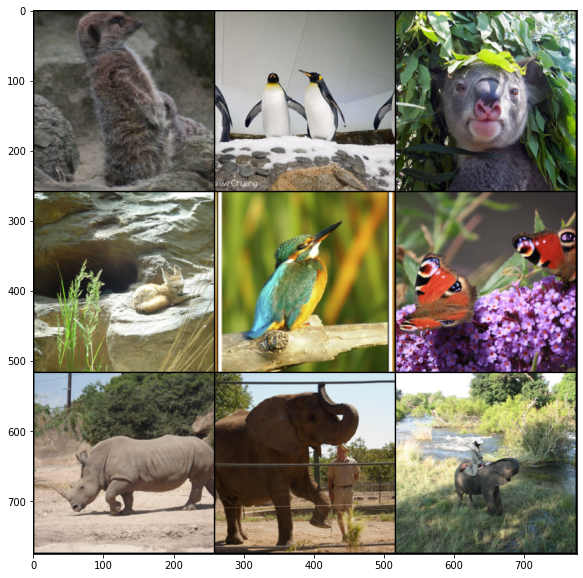

In [ ]:
img = make_grid(denorm(fixed_input), nrow=3, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
show(img)
# plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/MNIST.png', bbox_inches='tight')

## CNN Classifier with Pytorch

First have a play with all the code shown below and try to understand what it does.

Disclaimer: exactly what and how a convolution works is not part of this course. Rather treat it as a function which takes an inputs and a series of parameters and returns an output. For more information regarding convolutions please refer to the following links. 

An animation of an example convolution with in_channels = 1, out_channels=1, kernel_size = (3,3), padding = 1 and stride=1:

![conv](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)
- You can find a very nice CNN explainer here: https://poloclub.github.io/cnn-explainer/
- And some nice convolution visualisation here: https://github.com/vdumoulin/conv_arithmetic

**[TASK 1]** When hyperparameter tuning it is important to base your decisions on a validation set NOT the test set. To this end create a new dataloader called validation_dataloader. This will allow your test set to be truly unseen data!


**[TASK 2]** Here we have a simple convolution classifier. Once you have familiarised yourself with the architecture, spend some time trying to improve the accuracy of the model. Some areas which could prove fruitful:

- different optimizers (Adam, RMSProp, SGD, ...)
- different activation functions (relu, tanh, sigmoid, ...)
- add of remove some neurons
- add of remove some layers
- batch normalisation
- differential learning rates
- data augmentation
- residual connections

(the list is endless)

I will be interested in seeing your solutions. If you want to share, copy and paste your code into an email to hgc19@ic.ac.uk, with the final test accuracy in the subject of the email.

## Define hyperparameters

In [ ]:
# 1 epoch = one complete pass through the dataset
num_epochs = 10

# How fast to update the weights of the networks
# nice interactive tool to visualise effect of lr and momentum on SGD:
# https://distill.pub/2017/momentum/
learning_rate  = 1e-3 


## Define our model
Task: Investigate Conv2d. What are the arguments which it is parsed and what do they do?

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Here, we will use nn.Sequential to directly define the sequence of operations that will be performed IN ORDER by our model.

        # You can find a very nice CNN explainer here: https://poloclub.github.io/cnn-explainer/
        # And some nice convolution visualisation here: https://github.com/vdumoulin/conv_arithmetic

        # Defining all the operations that will be performed IN ORDER by our model. 
        blocks = [
            # First the data goes through a 2D convolutional Layer (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
            # in_channels=3 as each image has 3 channels (one for the red, one for the green and one for the blue color)
            # out_channels=32 corresponds to the number of channels outputted by the Conv2d Layer.
            # We use a kernel of size 3 to perform the convolutions
            # And a padding of 1 around each image in order to keep the same image dimensions in (in_channels) and (out_channels)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True), # Then it goes to a ReLU Activation function 
            nn.BatchNorm2d(32), # Performing a normalisation over the whole batch of data.
            nn.MaxPool2d(2,2), # Pooling layer, downscaling the images by 2 
            nn.Conv2d(32,64,3,padding=1), # And so on...
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,32,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,32,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,3,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        ]

        # Save the list of operations declared above as an nn.Sequential attribute
        self.blocks = nn.Sequential(*blocks) 

        self.FC1 = nn.Linear(192, 20)

    def forward(self, input_data):
        x = self.blocks(input_data) # Data passed to all the operations in nn.Sequential
        out = self.FC1(x.view(input_data.size()[0], -1))
        return out



## Define our training and test methods

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(epoch, loader_train, loader_test, model, device, optimizer, scheduler):
    
    loader_train = tqdm(loader_train, position=0)
    criterion = nn.CrossEntropyLoss()

    for i, (img, label) in enumerate(loader_train):
        model.zero_grad()
        # sending the images to the gpu!
        img = img.to(device)
        label = label.to(device)
        predicts_soft = model(img) # (batch, #classes)
        loss = criterion(predicts_soft, label)
        loss.backward()

        # get accuracy
        predicts = torch.argmax(predicts_soft, dim=1)
        correct = (predicts == label).float()
        accuracy = correct.sum() / label.numel()

        if scheduler is not None:
            scheduler.step()
        optimizer.step()

        lr = optimizer.param_groups[0]['lr']

        loader_train.set_description(
            (
                f'epoch: {epoch + 1}; acc: {accuracy.item():.5f}; '
                f'loss: {loss.item():.3f}'
            )
        )


def test(model, device, loader_test, confusion=False):

    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_correct = 0
    total_loss = 0
    total = 0
    for j, (test_img, test_label) in enumerate(loader_test):



        with torch.no_grad():
            test_img = test_img.to(device)
            test_label = test_label.to(device)
            predicts_soft = model(test_img) # (batch, #classes)
            test_loss = criterion(predicts_soft, test_label)
            total_loss += test_loss

        # get accuracy
        predicts = torch.argmax(predicts_soft, dim=1)
        correct = (predicts == test_label).float()
        total_correct += correct.sum()
        total += test_label.numel()


        if j == 0 and confusion:
            stack_labels = test_label
            stack_predicts = predicts
        elif confusion:
            stack_labels = torch.cat([stack_labels, test_label], 0)
            stack_predicts = torch.cat([stack_predicts, predicts], 0)

    model.train()
    
    print(f'test loss: {total_loss.item()/j}')
    print(f'test acc: {total_correct/total}')

    if confusion:
      
      # Plotting the confusion matrix
      labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
        'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
        'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
      cm = confusion_matrix(stack_labels.cpu().numpy(), stack_predicts.cpu().numpy())
      ax= plt.subplot()
      sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

      # labels, title and ticks
      ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
      ax.set_title('Confusion Matrix');
      ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels);
      plt.show()

      # lets see a sample of the images which were classified incorrectly!
      test_labels_check = correct.cpu().numpy()
      incorrect_indexes = np.where(test_labels_check == 0)

      test_img = test_img.cpu()
      samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                          padding=2, normalize=False, range=None, 
                          scale_each=False, pad_value=0)
      plt.figure(figsize = (20,10))
      plt.title('Incorrectly Classified Instances')
      show(samples)
      labels = np.asarray(labels)
      print('Predicted label',labels[predicts[incorrect_indexes].cpu().numpy()[:9]])
      print('True label', labels[test_label[incorrect_indexes].cpu().numpy()[:9]])
      print('Corresponding images are shown below')

 

  0%|          | 0/164 [00:00<?, ?it/s]

Total number of parameters is: 52151
Model(
  (blocks): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True

  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.78518921988351
test acc: 0.3100000023841858


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.319953645978655
test acc: 0.3850000202655792


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.267363956996373
test acc: 0.39500001072883606


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.1383138384137834
test acc: 0.42500001192092896


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.0311355590820312
test acc: 0.4480000138282776


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.355125972202846
test acc: 0.39000001549720764


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 1.972952433994838
test acc: 0.4790000319480896


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.1061559404645647
test acc: 0.4750000238418579


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 1.907310894557408
test acc: 0.4910000264644623


epoch: 10; acc: 0.60833; loss: 1.283: 100%|██████████| 164/164 [01:23<00:00,  1.97it/s]


test loss: 1.8142454964773995
test acc: 0.5139999985694885
test loss: 1.8104959215436662
test acc: 0.5139999985694885


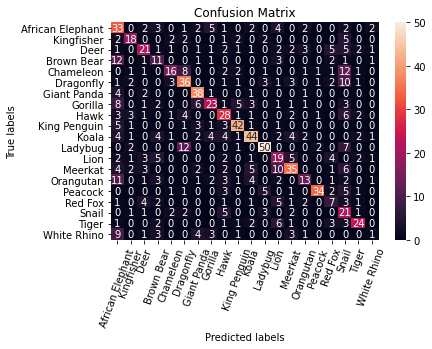

Predicted label ['Deer' 'Ladybug' 'Deer' 'Brown Bear' 'Ladybug' 'Snail' 'Red Fox' 'Lion'
 'Meerkat']
True label ['African Elephant' 'Chameleon' 'Red Fox' 'African Elephant' 'Snail'
 'Ladybug' 'Tiger' 'King Penguin' 'Dragonfly']
Corresponding images are shown below


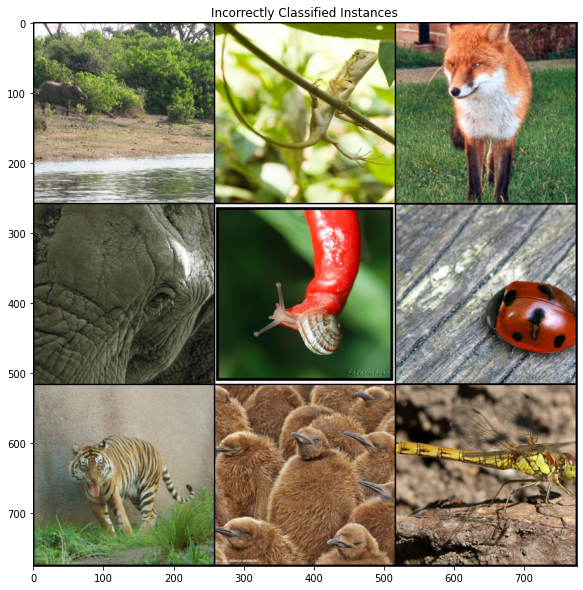

In [ ]:
# Training the model using ADAM optimiser

from tqdm import tqdm

model = Model().to(device) # Passing the classifier implemented above to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = None

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# Train model
for i in range(num_epochs):
    model.train()
    train(i, loader_train, loader_test, model, device, optimizer, scheduler)
    test(model, device, loader_test)

test(model, device, loader_test, confusion=True)

# Part 3: Building an Autoencoder in PyTorch
In this section the steps to build an autoencoder are detailed. The dataset being used is the famous MNIST dataset which consists of 60,000 hand written digits.

![autoencoder](https://drive.google.com/uc?id=1uG63uA9zDIDImDgp5c-rcRW67ltSlWYL)

Autoencoders consist of an encoder $E()$ and a decoder $D()$, parameterised by deep neural networks, $E_{\theta_1}(),D_{\theta_2}() $. The encoder learns to project the high dimensional input, $\pmb{x}_i$, onto the low dimensional latent space. The encoder performs the task of extracting the representations or features of the data. The decoder then learns to map the latent representations back to the input space. The figure above details the high level overview of the autoencoder.
\begin{equation}
    \pmb{z}_i = E_{\theta_1}(\pmb{x}_i)
\end{equation}
\begin{equation}
    \pmb{\tilde{x}}_i = D_{\theta_2}(\pmb{z}_i)
\end{equation}
Where $\mathbf{\tilde{x}}_i$ is the reconstructed data. Both encoder and decoder are trained to minimise the reconstruction loss, which is simply the difference between the input and reconstructed data. In the case of images, this can be the mean squared error (MSE) in pixel values.
\begin{equation}
    \min_{\theta_1, \theta_2}\sum_{i}^N\Big(\pmb{x}_i-D_{\theta_2}(E_{\theta_1}(\pmb{x}_i))\Big)^2
\end{equation}
Where $\theta_1, \theta_2$ represent the parameters of the encoder and decoder respectively and $N$ details the number of samples in one minibatch. 

**[TASK 3]** After familiarising yourself with the concepts and code shown below. Have a play around with the latent dimension size and see how this effects the reconstruction and generated quality. Why does this happen?

**[Task 4]** As you will have seen this is a simple Multi Layer Perceptron (MLP). This is okay as the image sizes are very small. Can you convert this Autoencoder into a convolutional autoencoder? *Hint: use the nn.Conv2d function from the previous question.*

**[Bonus Task]** The quality of generated images is not great. Why do you think this is? Can you implement an autoecoder with better quality generated images? *Hint: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html*

## Loading the data
note: datasets.MNIST automatically downloads the data. (datasets was imported from torchvision earlier)

In [ ]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))
])

def denorm(x):
    '''
    Function to reverse the normalization so that we can visulise the outputs
    '''
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x



train_dat = datasets.MNIST(
                            "data/",
                            train=True,
                            download=True,
                            transform=transform
)
test_dat = datasets.MNIST("data/",
                          train=False,
                          transform=transform
)

batch_size = 128 # the number of samples to process at once.
loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:100, :, :, :]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Visualise the dataset

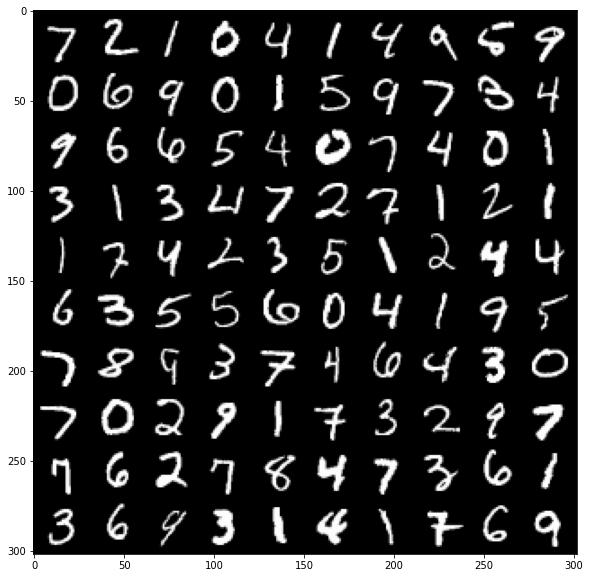

In [ ]:
img = make_grid(denorm(fixed_input), nrow=10, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(10,10))
show(img)
# plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/MNIST.png', bbox_inches='tight')

## Hyperparameter setting:

In [ ]:
# 1 epoch = one complete pass through the dataset
num_epochs = 10

# How fast to update the weights of the networks
learning_rate  = 3e-3 

# # The number of images to process in one go
batch_size = 128

# The number of dimensions of the hidden representation of our data
latent_dim = 10 # feel free to play around with this value and see what the effects are

## Defining the architecture of our model:

In [ ]:
class AE(nn.Module):
    def __init__(self, latent_dim):
        super(AE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.tanh = nn.Tanh()
        
        
    def encode(self, x):
        '''
        Encodes the image down to the latent space
        '''

        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

 
    def decode(self, z):
        '''
        Decodes back from the latent space to an image
        '''
        h3 = F.relu(self.fc3(z))
        return self.tanh(self.fc4(h3))
 
    
    def forward(self, x):

        z = self.encode(x.view(-1, 784))
        return self.decode(z)



model = AE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# Here we use Adam optimization, currently a state of the art algorithm 
# for gradient descent when updateing the network weights.
# Here is a great summary/introduction to the different types of optimisation
# commonly used in deep learning: https://ruder.io/optimizing-gradient-descent/
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 636794
AE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
  (tanh): Tanh()
)


## Start training!

In [ ]:
def test(epoch):
  '''
  using the test data, returns the test losses
  '''
  # set the model into evaluation mode (we do not want our model to learn from
  # the test set, otherwise it will overfit!)
  
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for i, (data, _) in enumerate(loader_test):
          data = data.to(device)
          recon_batch = model(data)
          loss_test = loss_function_AE(recon_batch, data)
          test_loss += loss_test.item()
          if i == 0:
              n = min(data.size(0), 8)
              comparison = torch.cat([data[:n],
                                    recon_batch.view(batch_size, 1, 28, 28)[:n]])
              # save_image(comparison.cpu(),
              #           'path to your directory' + str(epoch) + '.png', nrow=n)

  test_loss /= len(loader_test.dataset)
  print('====> Test set loss: {:.4f}'.format(test_loss))
  model.train()



def loss_function_AE(recon_x, x):
      
      # Binary cross entropy summed across all pixels
      # This is the reconstruction loss! (the sum of all the differences between pixel values)
      BCE = F.binary_cross_entropy(denorm(recon_x), denorm(x.view(-1, 784)), reduction='sum')

      return BCE

In [ ]:
model.train()

for epoch in range(num_epochs):     
        train_loss = 0
        for batch_idx, (data, _) in enumerate(loader_train):
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch = model(data)
          
          loss = loss_function_AE(recon_batch, data)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()
          if batch_idx % 10 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(loader_train.dataset),
                  100. * batch_idx / len(loader_train),
                  loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(loader_train.dataset)))
   
        test(epoch)



# save the model 
#torch.save(model.state_dict(), 'path to your directory/VAE_model.pth')

Train Epoch: 0 [0/60000 (0%)]	Loss: 548.839600
Train Epoch: 0 [1280/60000 (2%)]	Loss: 204.809509
Train Epoch: 0 [2560/60000 (4%)]	Loss: 184.423813
Train Epoch: 0 [3840/60000 (6%)]	Loss: 156.432632
Train Epoch: 0 [5120/60000 (9%)]	Loss: 146.607330
Train Epoch: 0 [6400/60000 (11%)]	Loss: 137.992432
Train Epoch: 0 [7680/60000 (13%)]	Loss: 127.726883
Train Epoch: 0 [8960/60000 (15%)]	Loss: 120.009491
Train Epoch: 0 [10240/60000 (17%)]	Loss: 118.739082
Train Epoch: 0 [11520/60000 (19%)]	Loss: 116.020813
Train Epoch: 0 [12800/60000 (21%)]	Loss: 113.326370
Train Epoch: 0 [14080/60000 (23%)]	Loss: 106.787056
Train Epoch: 0 [15360/60000 (26%)]	Loss: 111.719711
Train Epoch: 0 [16640/60000 (28%)]	Loss: 108.517181
Train Epoch: 0 [17920/60000 (30%)]	Loss: 113.019836
Train Epoch: 0 [19200/60000 (32%)]	Loss: 110.812408
Train Epoch: 0 [20480/60000 (34%)]	Loss: 103.610016
Train Epoch: 0 [21760/60000 (36%)]	Loss: 109.042145
Train Epoch: 0 [23040/60000 (38%)]	Loss: 102.153099
Train Epoch: 0 [24320/60000 

## Evaluating the performance of our training model.

Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


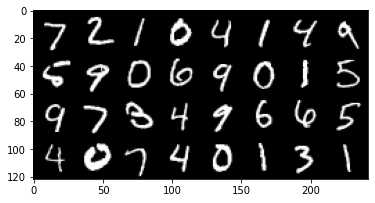

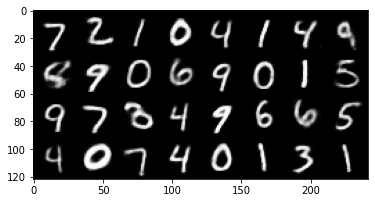

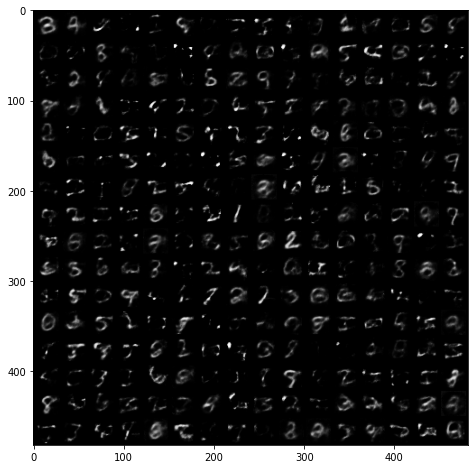

In [ ]:


print('Input images')
print('-'*50)

# If you would like to load a saved model
#model.load_state_dict(torch.load('path to your directory/VAE_model.pth'))


# Encoding and decoding images from the test set:

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)
# plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/Input_AE2.png', bbox_inches='tight')
print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    fixed_input = fixed_input.to(device)
    recon_batch = model(fixed_input)
  
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/Reconstruction_AE2.png', bbox_inches='tight')

# Sampling from the latent space to generate new images
print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():

    z = z.to(device)
    samples = model.decode(z)

    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/GeneratedImages_AE2.png', bbox_inches='tight')

## Viewing the 2D manifold

In [ ]:
if latent_dim != 2:
    print('Please change the latent space dimensions of the VAE to 2 if you would like to view the 2D manifold.')
else:  
  with torch.no_grad():
      
      # create a sample grid in 2d latent space
      latent_x = np.linspace(-1.5,1.5,20)
      latent_y = np.linspace(-1.5,1.5,20)
      latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
      for i, lx in enumerate(latent_x):
          for j, ly in enumerate(latent_y):
              latents[j, i, 0] = lx
              latents[j, i, 1] = ly
      latents = latents.view(-1, 2) # flatten grid into a batch

      # reconstruct images from the latent vectors
      latents = latents.to(device)
      image_recon = model.decode(latents)
      image_recon = image_recon.cpu()

      # fig, ax = plt.subplots(figsize=(10, 10))
      samples = make_grid(denorm(image_recon), nrow=20, padding=2, normalize=False,
                              range=None, scale_each=False, pad_value=0)
      plt.figure(figsize = (10,10))
      show(samples)
      # plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/manifoldAE1.png', bbox_inches='tight')
      # show_image(torchvision.utils.make_grid(denorm(image_recon.data[:400],20,5)))
      # plt.show()

Please change the latent space dimensions of the VAE to 2 if you would like to view the 2D manifold.
